In [2]:
%matplotlib notebook
import cvxpy as cp
import dccp
import torch
import numpy as np
from cvxpylayers.torch import CvxpyLayer
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import svm
from sklearn.metrics import zero_one_loss, confusion_matrix
from scipy.io import arff
import pandas as pd
import time
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.datasets import make_classification
from sklearn.utils import shuffle
import matplotlib.patches as mpatches
import json
import random
import math
import os, psutil
from datetime import datetime

SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIG_SIZE = 14

# Burden VS accuracy

[1.7538774976059708, 1.6692921786229078, 1.6742175950140337, 1.4383647542918732, 1.1594916401655162, 1.1695273205941576, 1.0142644826034335, 1.0618349662101163, 0.9496233780797932, 0.7787358043085709, 0.4974295560224394, 0.22936517074127605, 0.15830804545174967, 0.111309544284618, 0.09237479815405286, 0.0802124077305907, 0.07208490234767742, 0.07111118637474316, 0.08573652676777371, 2.177036340766456, 2.172199504483429, 2.1766966943227324, 2.156272400988439, 2.077486411842051, 1.8915177197242277]
[0.696, 0.6986666666666668, 0.7053333333333334, 0.7013333333333334, 0.7053333333333334, 0.696, 0.6946666666666668, 0.6813333333333333, 0.6786666666666666, 0.6613333333333333, 0.6346666666666667, 0.6066666666666667, 0.5800000000000001, 0.5453333333333334, 0.5373333333333334, 0.5333333333333333, 0.5306666666666666, 0.5306666666666666, 0.5333333333333333, 0.6946666666666668, 0.6946666666666668, 0.6946666666666668, 0.6946666666666668, 0.6946666666666668, 0.6973333333333334]


<IPython.core.display.Javascript object>


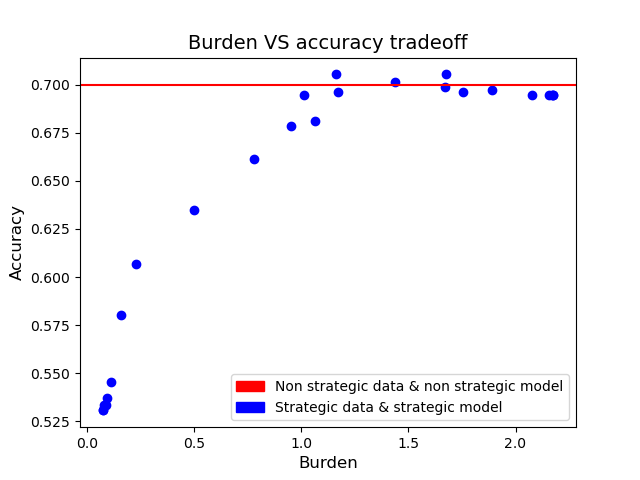

C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [3]:
burdens = []
accuracies = []
path = "C:/Users/sagil/Desktop/nir_project/models/burden/tradeoff_real2"

for root,d_names,f_names in os.walk(path):
    if "val_burdens.csv" in f_names:
        val_burdens = pd.read_csv(root + '/val_burdens.csv')
        burden = val_burdens.values[-1][1]
        burdens.append(burden)
        val_errors = pd.read_csv(root + '/val_errors.csv')
        acc = 1 - val_errors.values[-1][1]
        accuracies.append(acc)
        
print(burdens)
print(accuracies)
burdens.reverse()
accuracies.reverse()

fig = plt.figure()


plt.rc('axes', titlesize=BIG_SIZE)
plt.rc('axes', labelsize=MEDIUM_SIZE)
plt.title('Burden VS accuracy tradeoff')
plt.xlabel('Burden')
plt.ylabel('Accuracy')
ax = fig.add_subplot(111)
ax.scatter(burdens, accuracies, color='b')
plt.axhline(y=0.7, linestyle='-', color='r')

red_patch = mpatches.Patch(color='r', label='Non strategic data & non strategic model')
blue_patch = mpatches.Patch(color='b', label='Strategic data & strategic model')

plt.legend(handles=[red_patch, blue_patch])
plt.savefig(path + '/burden_vs_accuracy.pdf', format='pdf')
plt.savefig(path + '/burden_vs_accuracy.eps', format='eps')
plt.savefig(path + '/burden_vs_accuracy.png', format='png')
plt.show()

# Utility VS accuracy

[0.031290703903874874, 0.03173223843883554, 0.032260706179395984, 0.03221654227439755, 0.03248865780463652, 0.033773630004129036, 0.034634551051072424, 0.035037586385642104, 0.0365634327421774, 0.03794841691013024, 0.03984909883655219, 0.04210794466512927, 0.045581620290505116, 0.047606955701604683, 0.047515796995185176, 0.04966359676848802, 0.05473842524131122, 0.06021455324329681, 0.0639730756192904, 0.12464671381289792, 0.10503753003053876, 0.0971747764869939, 0.2224378197951399, 0.263559105593155, 0.6717842215461932, 0.860691256602617, 0.9266212754851044, 0.9436518624532528, 0.9625297278532374, 0.20994612606911228, 0.2292404582233284, 0.2613048217196312, 0.3039290618993893, 0.2845521866114164, 0.6159741018915853, 0.7242358974044542, 0.7980448463045181, 0.8315823573907278, 0.8652563271911482, 0.3704747803770904, 0.32871587409336944, 0.3824499311062696, 0.5982047988270942, 0.6387835090448792, 0.3780235846939274, 0.3952221911248957, 0.3937677343427881, 0.3985767595359488, 0.3972598850

<IPython.core.display.Javascript object>


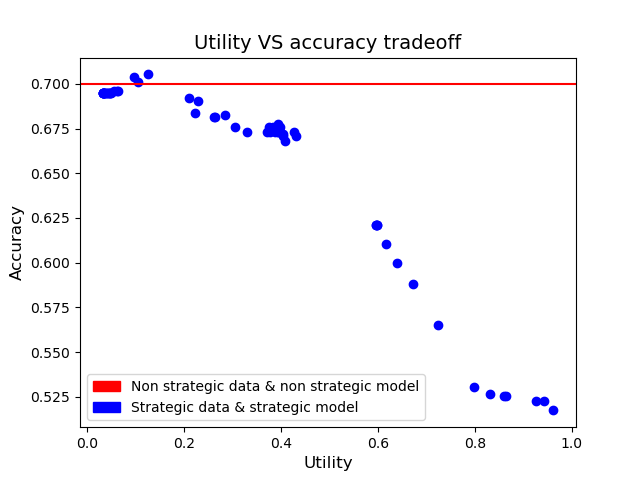

C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\ipykernel_launcher.py:26: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


In [48]:
utilities = []
accuracies = []
path = "C:/Users/sagil/Desktop/nir_project/models/utility/tradeoff_real3"

for root,d_names,f_names in os.walk(path):
    if "val_utilities.csv" in f_names:
        val_utilities = pd.read_csv(root + '/val_utilities.csv')
        utility = val_utilities.values[-1][1]
        utilities.append(utility)
        val_errors = pd.read_csv(root + '/val_errors.csv')
        acc = 1 - val_errors.values[-1][1]
        accuracies.append(acc)
        
print(utilities)
print(accuracies)
utilities.reverse()
accuracies.reverse()

fig = plt.figure()

plt.rc('axes', titlesize=BIG_SIZE)
plt.rc('axes', labelsize=MEDIUM_SIZE)
plt.title('Utility VS accuracy tradeoff')
plt.xlabel('Utility')
plt.ylabel('Accuracy')
ax = fig.add_subplot(111)
ax.scatter(utilities, accuracies, color='b')
plt.axhline(y=0.7, linestyle='-', color='r')

red_patch = mpatches.Patch(color='r', label='Non strategic data & non strategic model')
blue_patch = mpatches.Patch(color='b', label='Strategic data & strategic model')

plt.legend(handles=[red_patch, blue_patch])
# plt.savefig(path + '/utility_vs_accuracy.pdf', format='pdf')
# plt.savefig(path + '/utility_vs_accuracy.eps', format='eps')
# plt.savefig(path + '/utility_vs_accuracy.png', format='png')
plt.show()

# Recourse VS accuracy

[0.6100053252898746, 0.6100403582096388, 0.6096166723081278, 0.6096721093843332, 0.609742967148186, 0.6099460869366136, 0.6097336385072465, 0.6098815254784369, 0.6100714435122923, 0.6103188285019621, 0.6106330323804614, 0.6106647482509564, 0.6112849301807549, 0.6116020582503164, 0.6115572174032127, 0.6128184146797676, 0.612184659513652, 0.6125163791240811, 0.6154045407950416, 0.61779350084563, 0.6194041178945027, 0.6233122298719123, 0.6264477051803762, 0.6361254239888203, 0.6484925114334964, 0.681242878247643, 0.6583900411570889, 0.8681866485419303, 0.9349418354977826, 0.9534271142841574, 0.99999951548782, 0.6921038931303289, 0.764733395827215, 0.8370735206066114, 0.8926386351476836, 0.9193937760151104]
[0.6946666666666668, 0.6946666666666668, 0.6946666666666668, 0.6946666666666668, 0.6946666666666668, 0.6946666666666668, 0.6946666666666668, 0.6946666666666668, 0.6946666666666668, 0.6946666666666668, 0.6946666666666668, 0.6946666666666668, 0.6946666666666668, 0.6946666666666668, 0.6946

<IPython.core.display.Javascript object>


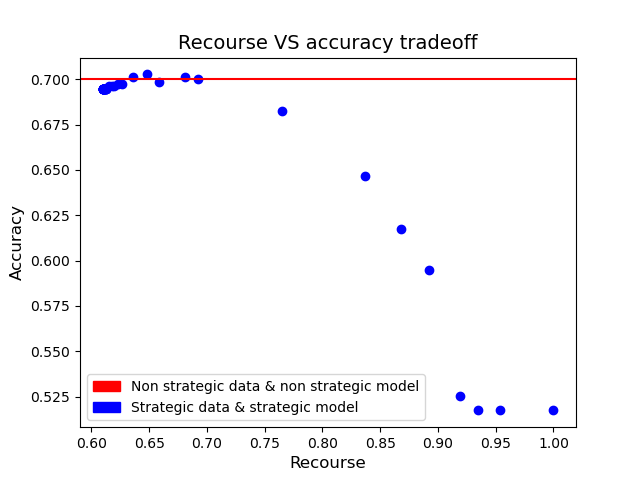

C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\ipykernel_launcher.py:44: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


In [46]:
recourses = []
accuracies = []
path = "C:/Users/sagil/Desktop/nir_project/models/recourse/tradeoff_real"

for root,d_names,f_names in os.walk(path):
    if "val_recourses.csv" in f_names:
        val_recourses = pd.read_csv(root + '/val_recourses.csv')
        recourse = val_recourses.values[-1][1]
        recourses.append(recourse)
        val_errors = pd.read_csv(root + '/val_errors.csv')
        acc = 1 - val_errors.values[-1][1]
        accuracies.append(acc)
        
print(recourses)
print(accuracies)
recourses.reverse()
accuracies.reverse()

fig = plt.figure()

plt.rc('axes', titlesize=BIG_SIZE)
plt.rc('axes', labelsize=MEDIUM_SIZE)
plt.title('Recourse VS accuracy tradeoff')
plt.xlabel('Recourse')
plt.ylabel('Accuracy')
ax = fig.add_subplot(111)
ax.scatter(recourses, accuracies, color='b')
plt.axhline(y=0.7, linestyle='-', color='r')

red_patch = mpatches.Patch(color='r', label='Non strategic data & non strategic model')
blue_patch = mpatches.Patch(color='b', label='Strategic data & strategic model')

plt.legend(handles=[red_patch, blue_patch])
# plt.savefig(path + '/recourse_vs_accuracy.pdf', format='pdf')
# plt.savefig(path + '/recourse_vs_accuracy.eps', format='eps')
# plt.savefig(path + '/recourse_vs_accuracy.png', format='png')
plt.show()

# Flexibility improvement

0.03589557650471357
[0.9035532994923858, 0.9441624365482234, 0.9137055837563451, 0.9238578680203046, 0.934010152284264, 0.9644670050761421, 0.9390862944162437, 0.9238578680203046, 0.9390862944162437, 0.8375634517766497, 0.7411167512690355, 0.8934010152284264, 0.9289340101522843, 0.7258883248730964]
[0.934010152284264, 0.949238578680203, 0.9187817258883249, 0.8781725888324873, 0.9441624365482234, 0.9695431472081218, 0.9441624365482234, 0.9441624365482234, 0.9390862944162437, 0.7918781725888325, 0.9441624365482234, 0.949238578680203, 0.9593908629441624, 0.949238578680203]


<IPython.core.display.Javascript object>


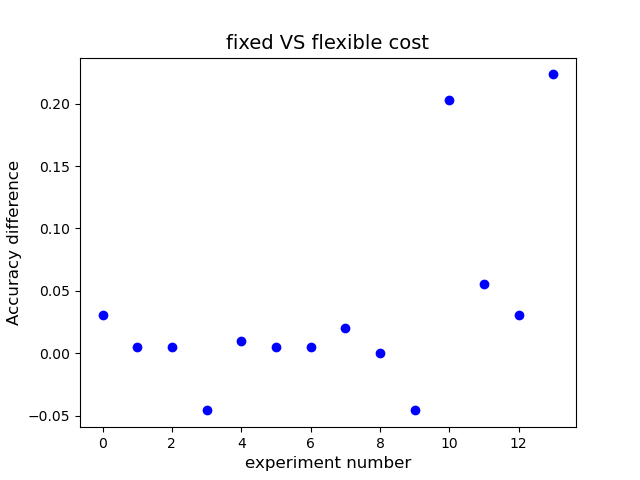

C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


In [17]:
fixed_accuracies = []
flexible_accuracies = []
path = "C:/Users/sagil/Desktop/nir_project/models/flexability/random_noise_ex"

for root,d_names,f_names in os.walk(path):
    if "fixed" in root:
        val_errors = pd.read_csv(root + '/val_errors.csv')
        acc = 1 - val_errors.values[-1][1]
        fixed_accuracies.append(acc)
    if "flexible" in root:
        val_errors = pd.read_csv(root + '/val_errors.csv')
        acc = 1 - val_errors.values[-1][1]
        flexible_accuracies.append(acc)
        
diffs = np.array(flexible_accuracies) - np.array(fixed_accuracies)
print(np.mean(diffs))
print(fixed_accuracies)
print(flexible_accuracies)

fig = plt.figure()

plt.rc('axes', titlesize=BIG_SIZE)
plt.rc('axes', labelsize=MEDIUM_SIZE)
plt.title('fixed VS flexible cost')
plt.xlabel('experiment number')
plt.ylabel('Accuracy difference')
ax = fig.add_subplot(111)
ax.scatter(np.arange(len(diffs)), diffs, color='b')
plt.show()


<IPython.core.display.Javascript object>


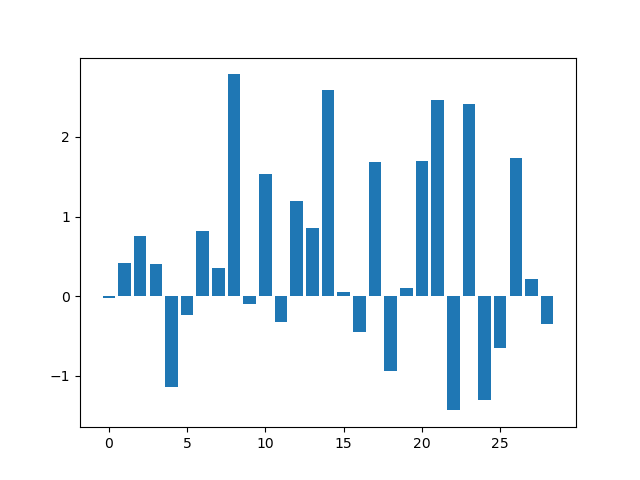

In [20]:
v_orig = torch.Tensor([-0.0083,  0.1438,  0.2624,  0.1383, -0.3927, -0.0812,  0.2853,  0.1248,
         0.9651, -0.0347,  0.5332, -0.1104,  0.4133,  0.2955,  0.8981,  0.0175,
        -0.1551,  0.5824, -0.3267,  0.0344,  0.5876,  0.8516, -0.4966,  0.8351,
        -0.4504, -0.2245,  0.6009,  0.0764, -0.1217])

v_orig /= torch.norm(v_orig, p=1)
v_orig *= 29

fig = plt.figure()
plt.bar(torch.arange(29),v_orig)
plt.show()
